In [2]:
'''
********************************************
*  Модуль генерации распределения весов и  *
*       эталонных данных о границах.       *
*                                          *
*                                          *
* Основные функции и классы:               *
*                                          *
*   points2weights - преобразует данные о  *
*       ключевых точках в распределения    *
*       весов (w) и бинарные изображения   *
*       границ (c).                        *
*           Входные данные формируются как *
*       показано в примере main.           *
*                                          *
*   load_wc - загрузка w и c из            *
*       файла *.npz.                       *
*                                          *
*   save_wc - запись w и c в файл *.npz.   *
*                                          *
*   make_weights_dataset - создаёт датасет *
*       из карт весов и эталонных данных.  *
********************************************
'''


from skimage.filters import gaussian

from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from skimage.draw import line
import numpy as np
import torch
import os


'''
********************************************
*            Функции генерации             *
********************************************
'''

def interpolate(values       : 'Таблица ключевых значений',
                num_per_step : 'Число промежуточных точек между ' + \
                                'двумя ключевыми' = 20 ,
                closed       : 'Флаг замкнутости контура' = False):
    '''
    Выполняет одномерную интерполяцию массива по нулевому измерению.
    (Используется в interpolate_points)
    '''
    
    # Проверка входных данных
    num_values = len(values)
    if num_values < 2:
        raise ValueError('В контуре должно быть минимум две точки!')
    if num_values < 3 and closed:
        raise ValueError('Для замыкания в контуре должно быть ' + \
                         'минимум три точки!')
    
    # В замкнутом контуре должны быть повторения значений с обеих сторон
    expanded_num_values = num_values
    if closed:
        values = np.vstack([values] * 3)
        expanded_num_values *= 3
    
    # Делаем сглаживание маскимального порядка
    if expanded_num_values > 3:
        kind = 'cubic'
    elif expanded_num_values > 2:
        kind = 'quadratic'
    else:
        kind = 'linear'
    
    # Создаём интерполятор
    interp = interp1d(np.arange(expanded_num_values), values.T, kind=kind)

    # Извлекаем точки
    if closed:
        return interp(np.linspace(num_values,
                                  num_values * 2,
                                  num_values * num_per_step + 1)).T
    else:
        return interp(np.linspace(0, num_values - 1,
                                  num_values * num_per_step + 1)).T


def interpolate_points(points       : 'Таблица координат ключевых точек.' + \
                                       'Значения в интервале [0:1]. '     + \
                                       'Строки - точки, столбцы - '       + \
                                       'оси координат изображения.'       ,
                       contrasts    : 'Таблица контрастов для каждой '     + \
                                       'точки по каждому из каналов. '     + \
                                       'Строки - точки, столбцы - каналы.' + \
                                       'изображения'                       ,
                       corners      : 'Вектор указателей на то, ' + \
                                      'что точка является угловой.',
                       num_per_step : 'Число промежуточных точек между ' + \
                                      'двумя ключевыми' = 20 ,
                       closed       : 'Флаг замкнутости контура' = False):
    
    # Проверка на непротиворечивость входных данных
    num_points = len(points)
    if num_points < 2:
        raise ValueError('Число точек в контуре не ' + \
                         'может быть меньше двух!')
    if num_points == 2 and closed:
        raise ValueError('Для замыкания в контуре ' + \
                         'должно быть минимум три точки!')
    
    # Упаковка координат точек и их контрастов в одну таблицу
    pac = np.hstack([points, contrasts.reshape(contrasts.shape[0], -1)])
    # pac - points and contrasts
    
    # Сглаживание ключевых точек из таблицы `pac` (интерполяция)
    if any(corners): # Если в контуре есть угловые точки
        # Подготовка данных о ключевых точках
        if closed:
            first_corner_ind = np.where(np.array(corners))[0][0]
            pac = np.vstack([pac[first_corner_ind:    , :],
                              pac[:first_corner_ind + 1, :]])
            corners = list(corners)
            corners = corners[first_corner_ind:] + \
                      corners[:first_corner_ind + 1]
        else:
            corners[0] = True
            corners[-1] = True
        
        # Сглаживание
        soft_pac = np.zeros((0, pac.shape[1]))
        start_ind = 0
        corner_inds = np.where(np.array(corners))[0]
        for ind in corner_inds[1:]:
            soft_pac_part = interpolate(pac[start_ind: ind + 1],
                                        num_per_step=num_per_step)
            soft_pac = np.vstack([soft_pac, soft_pac_part])
            start_ind = ind
    
    else: # Если в контуре угловых точек нет
        soft_pac = interpolate(pac,
                               num_per_step=num_per_step,
                               closed=closed)
    
    # Распаковка
    soft_points    = soft_pac[:, :2]
    soft_contrasts = soft_pac[:, 2:]
    
    return soft_points, soft_contrasts


def random_window4points(points, non_linear_scale=True, min_scale=0.025):
    '''
    Случайный размер и положение окна, в пределах которого расположены точки
    '''
    # Размер окна для ключевых точек
    points_scale = np.random.rand()
    if non_linear_scale:
        points_scale = points_scale ** 3  # Возводим в степень ради неравномерного распределения вероятностей
    if min_scale:
        points_scale = points_scale * (1 - min_scale) + min_scale
    
    if points_scale>1:
        print('!'*50)
        print(points_scale)
        print('!'*50)
    # Сдвиг окна для ключевых точек
    
    points_shift = np.random.rand(2) * (1 - points_scale)
    points = points * points_scale
    points[:, 0] += points_shift[0]
    points[:, 1] += points_shift[1]
    
    return points


def make_normals(points       : 'Таблица точек контура'           ,
                 aspect_ratio : 'Отношение ширины изображения ' + \
                                'к высоте, или размер изображения',
                 closed       : 'Флаг замкнутости контура'        ):
    
    '''Строит нормали к сглаженному контуру'''
    
    if len(aspect_ratio) > 1: # Если передан размер изображения
        im_size = aspect_ratio
        aspect_ratio = im_size[1] / im_size[0]
    
    d = 1 # Размер окна фильтра сглаживания = 2 * d + 1
    
    # Наращивание контуа на длину фильтра с каждой стороны
    if closed:
        points = np.vstack([points[-d:  , :],
                            points,
                            points[  : d, :]])
    else:
        points = np.vstack([points[  : d, :],
                            points,
                            points[-d:  , :]])
    
    # Масштабирование точек для учёта соотношения сторон
    points[:, 0] *= aspect_ratio
    
    # Построение касательной
    normals = points[2 * d:, :] - points[:-2 * d, :]
    
    # Разворот касательной на 90 градусов (получение нормали)
    normals /= np.linalg.norm(normals, axis=-1, keepdims=True)
    normals = np.hstack([normals[:,1:], -normals[:,:1]])
    
    # Распределение влияния рормали к сегменту на обе крайние точки и ...
    # нормализация этих векторов (приведение к единичной длине)
    for ind in range(1, len(normals)):
        pind = ind + d
        if all(np.equal(points[pind - 1, :], points[pind, :])):
            normal_mean = (normals[ind - 1, :] + normals[ind, :]) / 2
            #normal_mean /= np.linalg.norm(normal_mean, axis=-1, keepdims=True)
            normals[ind - 1, :] = normal_mean
            normals[ind    , :] = normal_mean
    
    # Если контур замкнут, то конечные точки должны иметь общую нормаль
    if closed and all(np.equal(points[d, :], points[-d, :])):
        normal_mean = (normals[0, :] + normals[-1, :]) / 2
        #normal_mean /= np.linalg.norm(normal_mean, axis=-1, keepdims=True)
        normals[ 0, :] = normal_mean
        normals[-1, :] = normal_mean
    
    return normals


def draw_gradient_field(soft_points    : 'Сглаженные контуры.'  ,
                        soft_contrasts : 'Cглаженные контрасты.',
                        soft_normals   : 'Cглаженные нормали.'  ,
                        image_size     : 'Размер изображения.'  ):
    '''
    Построение градиентного поля для многоканального изображения
    '''
    
    # Создание пустой матрицы градиентных поей
    gradient_field = np.zeros([image_size[0],
                               image_size[1],
                               soft_contrasts.shape[-1],
                               2])
    
    # Переход от (x, y) к (i, j)
    j = np.round(     soft_points[:,0]  * image_size[1]).astype(int)
    i = np.round((1 - soft_points[:,1]) * image_size[0]).astype(int)

    for ind in range(1, len(soft_points)):
        # Построение линии между двумя точками
        ii, jj = line(i[ind - 1], j[ind - 1], i[ind], j[ind])

        # Пропуск, если сегмент состоит из одного пикселя
        line_len = len(ii)
        if line_len == 1:
            continue
        
        # Проверка на выход за пределы изображения
        start_correct = end_correct = True # Флаги корректности концов сегмента
        
        for start in range(len(ii)):
            if (0 <= ii[start] < image_size[0]) and \
                    (0 <= jj[start] < image_size[1]):
                break
            else:
                start_correct = False
        else:        # Если сегмент целиком вышел за пределы изображения ...
            continue # ... то пропускаем сегмент.
        
        for end in reversed(range(len(ii))):
            if (0 <= ii[end] < image_size[0]) and \
                    (0 <= jj[end] < image_size[1]):
                break
            else:
                end_correct = False
        
        # Интерполяция контрастов
        cc = np.linspace(soft_contrasts[ind - 1, :],
                         soft_contrasts[ind    , :],
                         line_len)
        
        # Интерполяция нормалей
        nn = np.linspace(soft_normals[ind - 1, :],
                         soft_normals[ind    , :],
                         line_len)
        
        # Получение градиентов
        cc = np.expand_dims(cc, -1)
        nn = np.expand_dims(nn,  1)
        cc = np.repeat(cc, nn.shape[-1], -1)
        nn = np.repeat(nn, cc.shape[ 1],  1)
        gg = cc * nn

        # Нанесение градиентов на градиентное поле...
        # с учётом возможного выхода за границы изображения
        if start_correct and end_correct:
            gradient_field[ii[1: -1], jj[1: -1], ...] += gg[1: -1, ...]
            gradient_field[ii[[0, -1]], jj[[0, -1]], ...] += \
                                        gg[[0, -1], ...] / 2
        elif start_correct:
            end += 1
            gradient_field[ii[1: end], jj[1: end], ...] += gg[1: end, ...]
            gradient_field[ii[0], jj[0], ...] += gg[0, ...] / 2
        elif end_correct:
            gradient_field[ii[start: -1], jj[start: -1], ...] += \
                                          gg[start: -1, ...]
            gradient_field[ii[-1], jj[-1], ...] += gg[-1, ...] / 2
        else:
            end += 1
            gradient_field[ii[start: end], jj[start: end], ...] += \
                                            gg[start: end, ...]
        
    return gradient_field


def gf2weights(w          : 'Предварительное распределение весов',
               gf         : 'Целевое градиентное поле'           ,
               steps      : 'Число итераций'              = 3000 ,
               quiet      : 'Тихий режимж'                = True ,
               final_size : 'Итоговый размер изображений' = None):
    '''
    Построение весов по градиентам с использованием PyTorch
    '''
    # Лучшее достигнутое значение loss
    min_loss = torch.tensor(np.inf).cuda()
    
    # Скорость обучения (Learning rate)
    lr = torch.tensor(0.1).cuda()
    
    # "Терпение" перед понижением lr
    max_patience = torch.tensor(3).cuda()
    
    # Тензор градиентного поля
    gf = gf.transpose(0,3,1,2,4) # PyTorch shape = NCHW
    gf = torch.from_numpy(gf).cuda()
    
    # Размер тензора градиентных ополей
    gf_shape = gf.shape
    
    # Размер расширенной области изобаржения весов
    w_shape = [gf_shape[0]    ,
               gf_shape[1]    ,
               gf_shape[2] + 2,
               gf_shape[3] + 2]
    
    if w == None:
        # Если веса не заданы - создаём, заполняя нулями
        w = torch.autograd.Variable(torch.zeros(w_shape),
                                    requires_grad=True).cuda()
    else:
        if w.shape[2] != w_shape[2] or w.shape[3] != w_shape[3]:
            # Если веса заданы, но не соответствуют размеру - масштабируем
            w = torch.nn.functional.interpolate(w, w_shape[2:4], mode='bilinear', align_corners=True)

    
    # Цикл последовательного приближения...
    # градиентного поля w к заданному в gf
    for step in range(steps):
        
        # Вычисление loss
        '''
          t
        l c r
          b
        '''
        t = w[...,  :-2, 1:-1]
        l = w[..., 1:-1,  :-2]
        c = w[..., 1:-1, 1:-1]
        r = w[..., 1:-1, 2:  ]
        b = w[..., 2:  , 1:-1]
        dxloss = torch.square(l - c + gf[..., 0]) + torch.square(c - r + gf[..., 0])
        dyloss = torch.square(t - c - gf[..., 1]) + torch.square(c - b - gf[..., 1])
        loss = torch.mean(dxloss) + torch.mean(dyloss)
        
        # Получение и применение градиентов к весам
        grads = torch.autograd.grad(loss, w)[0]
        w -= grads / torch.abs(grads).max() * lr
        
        # Понижение скорости обучения, если это необходимо
        with torch.no_grad():
            if loss > min_loss:
                patience -= 1
                if patience < 1:
                    lr /= 2
                    patience = max_patience.clone()
                    if not quiet:
                        print('\tstep:', step,
                              ', lr:', lr.cpu().numpy(),
                              ', loss:', loss.cpu().numpy(),
                              ', min_loss:', min_loss.cpu().numpy())
            else:
                min_loss = loss
                patience = max_patience.clone()
    
    if final_size:
        # Если задан итоговый размер, значит это итоговая итерация.
        
        # Отключение автоградиента
        w = w.detach()
        
        # Обрезка
        w = w[..., 1:-1, 1:-1]
        
        # Масштабирование
        w = torch.nn.functional.interpolate(w, final_size, mode='bilinear', align_corners=True)
        
        # Вывод из GPU (и очистка памяти GPU)
        w_ = w.cpu().numpy()
        del min_loss, lr, max_patience, gf, gf_shape, w_shape, patience
        del t, l, c, r, b, dxloss, dyloss, loss
        del w, grads
        w = w_
        torch.cuda.empty_cache() # Очистка памяти на GPU
        
        # Возврат к формату TensorFlow
        w = w.transpose(0,2,3,1)
        
    return w


def points2weights(points_list,
                   contrasts_list,
                   corners_list,
                   closed_list,
                   im_size):
    
    # Дополняем списки сглаженными точками, контрастами и нормалями
    soft_points_list    = []
    soft_contrasts_list = []
    normals_list        = []
    for points, contrasts, corners, closed in zip(points_list,
                                                  contrasts_list,
                                                  corners_list,
                                                  closed_list):    
        # Интерполяция ключевых точек и контрастов
        try:
            soft_points, soft_contrasts = interpolate_points(points,
                                                             contrasts,
                                                             corners,
                                                             closed=closed)
        except ValueError: # Если ошибка входных данных - пропускаем
            continue

        # Получение нормалей
        normals = make_normals(soft_points, im_size, closed)
        
        # Дополнение списков
        soft_points_list   .append(soft_points   )
        soft_contrasts_list.append(soft_contrasts)
        normals_list       .append(normals       )
    
    
    # Формируем список размеров изображения
    down_scale_size = [im_size[0] * 2,
                       im_size[1] * 2]
    im_size_list = [down_scale_size]
    while True:
        down_scale_size = [down_scale_size[0] // 2,
                           down_scale_size[1] // 2]
        if min(down_scale_size) > 32:
            im_size_list.append(down_scale_size)
        else:
            break
    im_size_list = im_size_list[::-1]
    
    # Перебор по разным размерам
    im_size_list_len = len(im_size_list)
    final_size = None
    w = None
    for im_size_ind in range(im_size_list_len):
        
        # Текущий размер изображения
        cur_im_size = im_size_list[im_size_ind]
        
        # Сбор всех градиентных полей этого масштаба в один пакет
        gf = []
        for sample_ind in range(len(normals_list)):
            soft_points    =    soft_points_list[sample_ind]
            soft_contrasts = soft_contrasts_list[sample_ind]
            normals        =        normals_list[sample_ind]
            # Отрисовка градиентных полей
            gradient_field = draw_gradient_field(soft_points,
                                                 soft_contrasts,
                                                 normals,
                                                 cur_im_size)
            gf.append(gradient_field)
        gf = np.stack(gf, 0)
        
        # Если масштаб соответсвует целевому - бинаризируем gf в c
        if list(cur_im_size) == list(im_size):
            c = gf.any((-1,-2))
        
        # Если это последнее выполнение цикла
        if im_size_ind == im_size_list_len - 1:
            final_size = im_size
        
        w = gf2weights(w, gf, steps=100, final_size=final_size)

    return w, c


def draw_line(soft_points    : 'Сглаженные контуры.'  ,
              soft_contrasts : 'Cглаженные контрасты.',
              image_size     : 'Размер изображения.'  ):
    '''
    Построение линии на многоканальном изображении
    (аналог draw_gradient_field).
    '''
    
    # Создание пустой матрицы градиентных поей
    line_map = np.zeros([image_size[0],
                         image_size[1],
                         soft_contrasts.shape[-1]])
    
    # Переход от (x, y) к (i, j)
    j = np.round(     soft_points[:,0]  * image_size[1]).astype(int)
    i = np.round((1 - soft_points[:,1]) * image_size[0]).astype(int)
    
    for ind in range(1, len(soft_points)):
        # Построение линии между двумя точками
        ii, jj = line(i[ind - 1], j[ind - 1], i[ind], j[ind])
        
        # Пропуск, если сегмент состоит из одного пикселя
        line_len = len(ii)
        if line_len == 1:
            continue
        
        # Проверка на выход за пределы изображения
        start_correct = end_correct = True # Флаги корректности концов сегмента
        
        for start in range(len(ii)):
            if (0 <= ii[start] < image_size[0]) and \
                    (0 <= jj[start] < image_size[1]):
                break
            else:
                start_correct = False
        else:        # Если сегмент целиком вышел за пределы изображения ...
            continue # ... то пропускаем сегмент.
        
        for end in reversed(range(len(ii))):
            if (0 <= ii[end] < image_size[0]) and \
                    (0 <= jj[end] < image_size[1]):
                break
            else:
                end_correct = False
        
        # Интерполяция контрастов
        cc = np.linspace(soft_contrasts[ind - 1, :],
                         soft_contrasts[ind    , :],
                         line_len)
        
        # Нанесение градиентов на градиентное поле ...
        # с учётом возможного выхода за границы изображения
        if start_correct and end_correct:
            line_map[ii, jj, ...] = cc
        elif start_correct:
            end += 1
            line_map[ii[1: end], jj[1: end], ...] += cc[1: end, ...]
            line_map[ii[0], jj[0], ...] += cc[0, ...] / 2
        elif end_correct:
            line_map[ii[start: -1], jj[start: -1], ...] += cc[start: -1, ...]
            line_map[ii[-1], jj[-1], ...] += cc[-1, ...] / 2
        else:
            end += 1
            line_map[ii[start: end], jj[start: end], ...] += cc[start: end, ...]
        
    return line_map


def line_thickener(line_map, sigma=1):
    '''
    Утолщает линию гауссовским размытием с нелинейностью
    '''
    line_map = gaussian(line_map, sigma) * (np.pi * sigma ** 2)
    
    # Нелинейность
    line_map[line_map > 1] = 1
    line_map[line_map < -1] = -1
    
    return line_map


def points2line(points    : 'Ключевые точки',
                contrasts : 'Контрасты',
                corners   : 'Флаги углов',
                im_size   : 'Размер изображения',
                sigma     : 'Степень размытия (утолщения) линии'=None):
    '''
    Построение линии на многоканальном изображении по ключевым точкам.
    '''
    soft_points, soft_contrasts = interpolate_points(points,
                                                     contrasts,
                                                     corners)
    
    line_map = draw_line(soft_points, soft_contrasts, im_size)
    
    if sigma:
        line_map = line_thickener(line_map, sigma)
        
    return line_map

def LineMapGenerator(imsize):
    while True:
        line_n         = np.random.randint(2, 6)                 # Число ключевых точек
        line_points    = np.random.rand(line_n, 2)               # Ключевые точки
        line_contrasts = np.random.rand(line_n, 1)               # Контрасты в ключевых точках
        line_corners   = np.random.choice([True, False], line_n) # Флаги для угловых точекы
        
        #line_points = random_window4points(line_points) # Локализация кривой
        line_points = random_window4points(line_points, False, 1 / 256) # Локализация кривой
        
        
        # Модифицируем контрасты
        line_contrasts = (line_contrasts + 1) / 2
        if np.random.choice([True, False]):
            line_contrasts[0] = 0
        if line_n > 2 and np.random.choice([True, False]):
            line_contrasts[-1] = 0
        
        line_map = points2line(line_points,
                               line_contrasts,
                               line_corners,
                               imsize)
        
        line_gt = line_map
        line_sigma = np.random.rand() * 1 + 0.1 # Степень утолщения (размытия) линий
        line_map = line_thickener(line_map, line_sigma)
        yield line_map, line_gt

'''
********************************************
*           Функции отображения            *
********************************************
'''

def show_curve(points, corners, soft_points):
    plt.plot(points[:,0], points[:,1], alpha=0.3, label='Несглаженный контур')
    plt.plot(points[corners,0], points[corners,1], 'o', label='Угловые точки')
    plt.plot(points[np.invert(corners),0], points[np.invert(corners),1], 'p', label='Сглаживаемые точки')
    plt.plot(soft_points[:,0], soft_points[:,1], label='Сглаженный контур');
    for ind in range(points.shape[0]):
        plt.text(points[ind,0], points[ind,1], str(ind))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('Контур и ключевые точки')
    plt.legend()
    plt.gca().set_aspect(1)

def show_normals(soft_points, normals):
    plt.plot(soft_points[:,0], soft_points[:,1])
    for ind in range(len(soft_points)):
        x, y = soft_points[ind, :]
        dx, dy = normals[ind, :] / 10
        plt.plot([x, x + dx], [y, y + dy], 'r')
    plt.xlim([0, 1])
    plt.ylim([0, 1]);
    plt.title('Контур и нормали')
    plt.legend(['Контур', 'Нормали'])
    plt.gca().set_aspect(1)

def show_raster_gradient_field(gradient_field):
    gfx = gradient_field[:, :, :, 0].copy()
    if gfx.shape[-1] < 2:
        gfy = gradient_field[:, :, :, 1].copy()
        gfx = np.stack([gfx, gfy, np.zeros_like(gfx)], 2)[:, :, :, 0]
    gfx -= gfx.min()
    gfx /= gfx.max()
    plt.imshow(gfx)
    plt.axis(False);
    plt.title('Растровое представление/nградиентного поля')
    plt.gca().set_aspect(1)

def show_vector_gradient_field(gradient_field, im_size, step=1):
    for i in range(0, gradient_field.shape[0], step):
        for j in range(0, gradient_field.shape[1], step):
            dx, dy = gradient_field[i, j, 0, :] * 100
            if np.abs(dx)==np.abs(dy)==0:
                continue
            x = [im_size[0] - i, im_size[0] - (i - dy)]
            y = [j, j + dx]
            plt.plot(y, x, 'r')
    plt.xlim(0, im_size[1])
    plt.ylim(0, im_size[0])
    plt.plot(soft_points[:, 0] * im_size[1],
             soft_points[:, 1] * im_size[0])
    plt.title('Векторное представление/nградиентного поля')
    plt.gca().set_aspect(1)

def show_weights(weights):
    weights = weights.copy()
    weights -= weights.min()
    weights /= weights.max()
    if weights.shape[-1] < 3:
        plt.imshow(weights[..., 0], cmap='gray')
    else:
        plt.imshow(weights)
    plt.axis(False)
    plt.title('Распределение весов')


'''
********************************************
*           Загрузка / сохранение          *
********************************************
'''

def load_wc(file_name):
    '''
    Чтение весов и контуров из файла
    '''
    
    # Дополняем путь, если не указано расширение
    if file_name[-4:].lower() != '.npz':
        file_name += '.npz'
    
    file = np.load(file_name)
    w = file['w']
    c = file['c']
    file.close()
    return w, c

def save_wc(file_name, w, c):
    '''
    Запись весов и контуров в файл
    '''
    
    # Дополняем путь, если не указано расширение
    if file_name[-4:].lower() != '.npz':
        file_name += '.npz'
    
    np.savez(file_name, w=w, c=c)

    
'''
********************************************
*        Генерация датасета карт весов     *
********************************************
'''

def make_weights_dataset(path       : 'Каталог, в который будут сохраняться npz-файлы'='/mnt/disk/user/shubin/Weights',
                         im_size    : 'Размер изображений'=(512, 512), # (больше при 512х512 в 1080ti может не влезть)
                         batch_size : 'Размер минивыборки'=32,
                         total_num  : 'Размер всей выборки'=1000000,
                         quiet      : 'Безшумный режим'=False):
    '''
    Генерирует карту весов для границ случайной формы и сохраняет их
    вместе с эталонными данными о границах в файлы *.npz. Веса
    принимают значения в интервале [-1, 1], Эталонные данные -
    {True, False}.
    '''
    if not os.path.exists(path):
        os.makedirs(path)
    
    def file_ind2file_name(file_ind):
        return os.path.join(path, '%08d.npz' % file_ind)

    for file_ind in tqdm(range(total_num), disable=quiet):

        # Поиск первого несохранённого индекса семпла
        if os.path.exists(file_ind2file_name(file_ind)):
            continue

        # Генерация списков случайных ключевых точек
        points_list    = []
        contrasts_list = []
        corners_list   = []
        closed_list    = []
        for sample_ind in range(batch_size):
            n         = 3                                  # Число ключевых точек
            points    = np.random.rand(n, 2)               # Ключевые точки
            contrasts = np.ones((n, 1))                    # Контрасты в ключевых точках
            corners   = np.random.choice([True, False], n) # Флаги для угловых точек
            closed    = False                              # Замкнутость контура
            
            #points = random_window4points(points) # Локализация кривой
            points = random_window4points(points, False, 1 / 256) # Локализация кривой
            
            points_list   .append(points   )
            contrasts_list.append(contrasts)
            corners_list  .append(corners  )
            closed_list   .append(closed   )
        
        # Пакетная генерация весов
        w, c = points2weights(points_list,
                           contrasts_list,
                             corners_list,
                              closed_list,
                                  im_size)
        
        for ind in range(c.shape[0]):
            if np.sum(c[ind]) == 0:
                print('=' * 10)
                print(points_list[ind])
                print(corners_list[ind])
            
        
        
        # Сохранение каждого семлпа в отдельный файл
        for weights, contours in zip(w, c):
            file_name = file_ind2file_name(file_ind)
            while os.path.exists(file_name):
                file_ind += 1
            save_wc(file_name, weights, contours)
            file_ind += 1                         
    


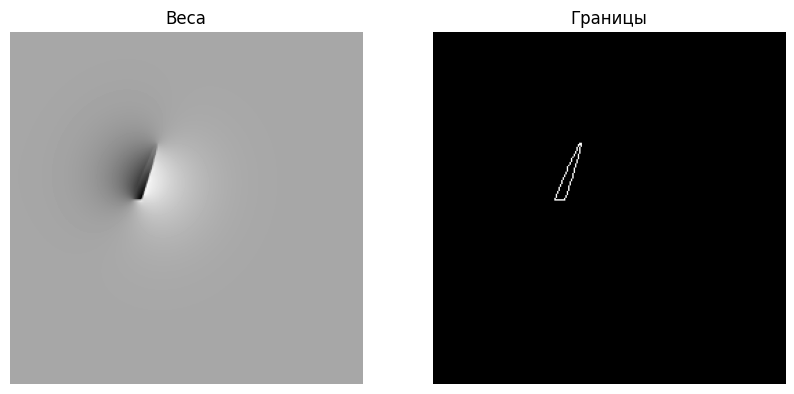

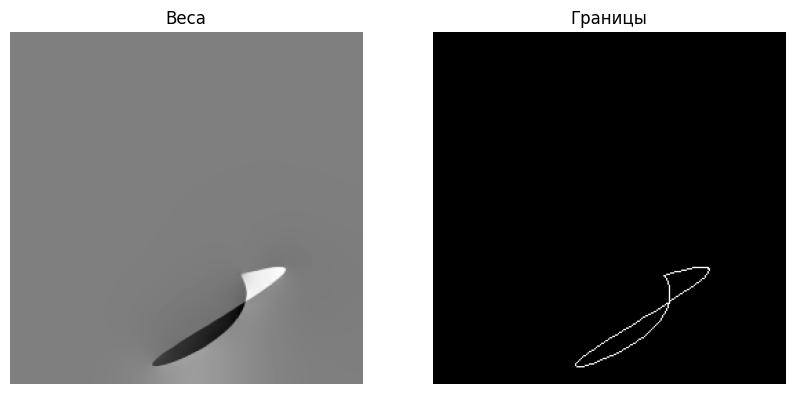

In [56]:
#######################################################
#                                                     #
#                  Генератор весов                    #
#                                                     #
#######################################################


#######################################################
# Загрузка модулей (уже загруженные закомментированы) #
#######################################################

#from weightsmap import points2weights
#from matplotlib import pyplot as plt
#import numpy as np


#######################################################
#              Создание ключевых точек                #
#######################################################

im_size    = [256, 256] # Целевой размер изображения
batch_size = 4          # Размер минивыборки

points_list    = []
contrasts_list = []
corners_list   = []
closed_list    = []

for sample_ind in range(batch_size):
    n         = np.random.randint(2, 6)            # Число ключевых точек
    
    points    = np.random.rand(n,2)                # Ключевые точки
    contrasts = np.random.rand(n,1)                # Контрасты в ключевых точках
    corners   = np.random.choice([True, False], n) # Флаги для угловых точек
    closed    = np.random.choice([True, False]   ) # Замкнутость контура
    
    #points = random_window4points(points) # Локализация кривой
    points = random_window4points(points, False, 1 / 100) # Локализация кривой
    
    points_list   .append(points   )
    contrasts_list.append(contrasts)
    corners_list  .append(corners  )
    closed_list   .append(closed   )
    

#######################################################
#             Генерация обучающих данных              #
#######################################################

w, c = points2weights(points_list,
                    contrasts_list,
                        corners_list,
                        closed_list,
                            im_size)


#######################################################
#              Отображение результатов                #
#######################################################
for weights, conturs in zip(w, c):
    plt.figure(figsize=(10, 8))
    plt.subplot(121); plt.imshow(weights        , cmap='gray'); plt.axis(False); plt.title('Веса')
    plt.subplot(122); plt.imshow(conturs        , cmap='gray'); plt.axis(False); plt.title('Границы')
plt.show()

In [61]:
import cv2

im_size    = [256, 256] # Целевой размер изображения
batch_size = 100          # Размер минивыборки

points_list    = []
contrasts_list = []
corners_list   = []
closed_list    = []

for sample_ind in range(batch_size):
    n         = np.random.randint(2, 6)            # Число ключевых точек
    
    points    = np.random.rand(n,2)                # Ключевые точки
    contrasts = np.random.rand(n,1)                # Контрасты в ключевых точках
    corners   = np.random.choice([True, False], n) # Флаги для угловых точек
    closed    = np.random.choice([True, False]   ) # Замкнутость контура
    
    #points = random_window4points(points) # Локализация кривой
    points = random_window4points(points, False, 1 / 10) # Локализация кривой
    
    points_list   .append(points   )
    contrasts_list.append(contrasts)
    corners_list  .append(corners  )
    closed_list   .append(closed   )
    

w, c = points2weights(points_list,
                    contrasts_list,
                        corners_list,
                        closed_list,
                            im_size)

id = 0

for weights, conturs in zip(w, c):
    int_conturs = np.array(conturs, dtype=np.int32)
    int_conturs[conturs] = 255
    cv2.imwrite(f'./dataset/labels/{id}.jpg', int_conturs)

    #cv2.imwrite(f'./dataset/images/{id}.jpg', weights)
    
    np.save(f'./dataset/images/{id}.npy', weights)
    weights_scaled = (((weights - weights.min()) / (weights.max() - weights.min())) * 255).clip(0, 255).astype(np.uint8)
    #cv2.imwrite(f'./dataset/images/{id}.jpg', cv2.cvtColor(weights * 255, cv2.COLOR_GRAY2BGR))
    cv2.imwrite(f'./dataset/images/{id}.jpg', weights_scaled)
    id += 1